### Q4. Natural Language Processing in Python: Unsupervised Machine Learning
Using central bank communications from the folder (Communication), group the 100 documents into 15 topics using the Latent Dirichlet Allocation (LDA). 

#### a)	Please prepare a well-commented Python script/notebook that shows the data preprocessing steps and the LDA. Please provide a label for each topic.

#### b)	Compute the sentiment of each document using FINBERT. 

#### c)	Please present a workflow chart illustrating the steps of your analysis along with the techniques/functions used in each step.

### Load and Extract Communication Documents

Importing libraries and all `.txt` and `.pdf` files from the zip archive and read their contents. 
Text from each document is stored in a list, enabling further analysis.


In [3]:
!pip install pymupdf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import fitz #for reading pdf files
import re

In [4]:
import zipfile
import os
import glob
import fitz  # part of pymupdf for PDF handling

# Define the folder path for extraction
zip_path = "Communication.zip"
extraction_path = "/content/Communication"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Get a list of all .txt and .pdf files in the extracted folder
file_paths = glob.glob(os.path.join(extraction_path, '*'))
print(f"Number of files found: {len(file_paths)}")  # This will display the number of files

# Read all documents
documents = ['' for _ in range(len(file_paths))]

for i, file_path in enumerate(file_paths):
    if file_path.endswith('.txt'):
        # Read text files
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            documents[i] = content
    elif file_path.endswith('.pdf'):
        # Read pdf files
        pdf_content = ""
        with fitz.open(file_path) as pdf_file:
            for page_num in range(pdf_file.page_count):
                page = pdf_file[page_num]
                pdf_content += page.get_text()
        documents[i] = pdf_content

print("Document reading complete.")


Number of files found: 100
Document reading complete.


### Preprocess Document Text

This part cleans PDF text by removing newlines, extra spaces, isolated symbols, and unwanted content in square brackets. It is applied to each document in the dataset, preparing the text for further analysis.


In [6]:
#preprocess dataset
def clean_pdf_text(text):
    # Step 1: Remove newlines and multiple spaces
    text = re.sub(r'\n+', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    # Step 2: Remove page numbers and unnecessary symbols
    #text = re.sub(r'\s*\d+\s*', ' ', text)  # Remove standalone numbers (page numbers)
    text = re.sub(r'\s*\.\s*', ' ', text)  # Remove isolated periods
    text = re.sub(r'\[.*?\]', ' ', text)  # Remove text within square brackets (if any)

    #text = text.lower()

    return text

for i, (content, file_path) in enumerate(zip(documents, file_paths)):
    if file_path.endswith('.pdf'):
        documents[i] = clean_pdf_text(content)


In [7]:
file_idx = 1
print(file_paths[file_idx])
print(documents[file_idx][:1000])

/content/Communication\2010_01_26.pdf
1 January 26, 2010 Bank of Japan Statement on Monetary Policy 1 At the Monetary Policy Meeting held today, the Policy Board of the Bank of Japan decided, by a unanimous vote,1 to set the following guideline for money market operations for the intermeeting period: The Bank of Japan will encourage the uncollateralized overnight call rate to remain at around 0 1 percent 2 Japan's economy is picking up mainly due to various policy measures taken at home and abroad, although there is not yet sufficient momentum to support a self-sustaining recovery in domestic private demand Exports and production have been increasing against a backdrop of progress in inventory adjustments both at home and abroad as well as an improvement in overseas economies, especially, fast growth in emerging economies The decline in business fixed investment has been coming to a halt Private consumption, notably durable goods consumption, is picking up mainly due to policy measures

### Topic Modeling with LDA

This code applies Latent Dirichlet Allocation (LDA) to identify topics within the documents. After removing stopwords and non-alphabetic words, each document is tokenized, and an LDA model is built with 15 topics. The top keywords for each topic are displayed, helping to interpret the topic clusters.


In [9]:
import nltk
from gensim import corpora, models
from nltk.corpus import stopwords
from gensim.models import CoherenceModel

In [10]:
# Download stopwords
nltk.download('stopwords')

# Load stopwords for English
stop_words = set(stopwords.words('english'))

# Preprocess text for LDA
def preprocess_text(text):
    # Tokenize, remove stopwords, and non-alphabetic words
    tokens = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return tokens

# Apply preprocessing to all documents
processed_docs = [preprocess_text(doc) for doc in documents]

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(processed_docs)
corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Build the LDA model
num_topics = 15
lda_model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42)

# Display topics with their top keywords
print("Topics and Top Keywords:")
for idx, topic in lda_model.show_topics(formatted=False):
    top_keywords = [word for word, prob in topic]
    print(f"Topic {idx + 1}: {top_keywords}")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topics and Top Keywords:
Topic 3: ['New', 'percent', 'inflation', 'Zealand', 'The', 'Bank', 'Reserve', 'growth', 'Policy', 'rate']
Topic 14: ['inflation', 'The', 'rate', 'policy', 'monetary', 'growth', 'Policy', 'New', 'market', 'per']
Topic 12: ['forecasts', 'Policy', 'Board', 'CPI', 'Forecasts', 'The', 'Fiscal', 'January', 'members', 'October']
Topic 11: ['inflation', 'The', 'rate', 'growth', 'rates', 'prices', 'New', 'economic', 'In', 'interest']
Topic 7: ['Mr', 'Bank', 'The', 'Policy', 'financial', 'growth', 'rate', 'Japan', 'economic', 'economy']
Topic 2: ['The', 'inflation', 'rate', 'growth', 'New', 'Bank', 'policy', 'market', 'Policy', 'monetary']
Topic 8: ['The', 'Bank', 'shall', 'yen', 'purchased', 'ETFs', 'trillion', 'bonds', 'amount', 'purchases']
Topic 1: ['inflation', 'rate', 'The', 'policy', 'monetary', 'growth', 'per', 'forecast', 'expected', 'prices']
Topic 10: ['rate', 'inflation', 'profile', 'successive', 'policy', 'The', 'followed', 'monetary', 'Bank', 'Policy']
Topi

### Sentiment Analysis with FinBERT

This part of the code uses the FinBERT model to analyze the sentiment of each document, predicting whether it is positive, neutral, or negative. Each document’s sentiment and confidence score are computed and displayed, with progress tracking across all documents.


In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
from tqdm import tqdm
from collections import Counter

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load FinBERT model and tokenizer
model_id = 'ProsusAI/finbert'
model = AutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


In [14]:
# Compute sentiment for each document with a progress bar
document_sentiments = []
for file_path, doc in tqdm(zip(file_paths, documents), total=len(documents), desc="Processing Documents"):
    # Process up to 512 tokens per document
    sentiment_result = sentiment_pipeline(doc[:512])  # Adjust slicing for longer texts if needed
    document_sentiments.append({
        "File Path": os.path.basename(file_path),
        "Sentiment": sentiment_result[0]['label'],
        "Score": sentiment_result[0]['score']
    })

# Display sentiment results for each document with file paths
for result in document_sentiments:
    print(f"Document: {result['File Path']}\nSentiment: {result['Sentiment']}, Score: {result['Score']:.4f}\n")

Processing Documents: 100%|██████████| 100/100 [00:26<00:00,  3.78it/s]

Document: 2010_01_04.txt
Sentiment: negative, Score: 0.5903

Document: 2010_01_26.pdf
Sentiment: positive, Score: 0.8198

Document: 2010_02_18.pdf
Sentiment: positive, Score: 0.8175

Document: 2010_02_24.txt
Sentiment: negative, Score: 0.8760

Document: 2010_03_17.pdf
Sentiment: neutral, Score: 0.8338

Document: 2010_03_18.pdf
Sentiment: neutral, Score: 0.8962

Document: 2010_04_07.pdf
Sentiment: positive, Score: 0.9048

Document: 2010_04_30.pdf
Sentiment: neutral, Score: 0.8804

Document: 2010_05_03.txt
Sentiment: neutral, Score: 0.8686

Document: 2010_05_21.pdf
Sentiment: positive, Score: 0.8648

Document: 2010_06_15.pdf
Sentiment: positive, Score: 0.9270

Document: 2010_07_15.pdf
Sentiment: positive, Score: 0.9269

Document: 2010_07_15.txt
Sentiment: neutral, Score: 0.7767

Document: 2010_08_10.pdf
Sentiment: positive, Score: 0.9265

Document: 2010_08_30.pdf
Sentiment: positive, Score: 0.9148

Document: 2010_08_31.pdf
Sentiment: neutral, Score: 0.9021

Document: 2010_09_07.pdf
Senti

### Sentiment Score Distribution and Classification Counts

This code visualizes the sentiment scores across documents by creating histograms for positive, neutral, and negative scores. Additionally, it displays a bar chart showing the count of documents classified into each sentiment category, providing insights into the overall sentiment distribution.


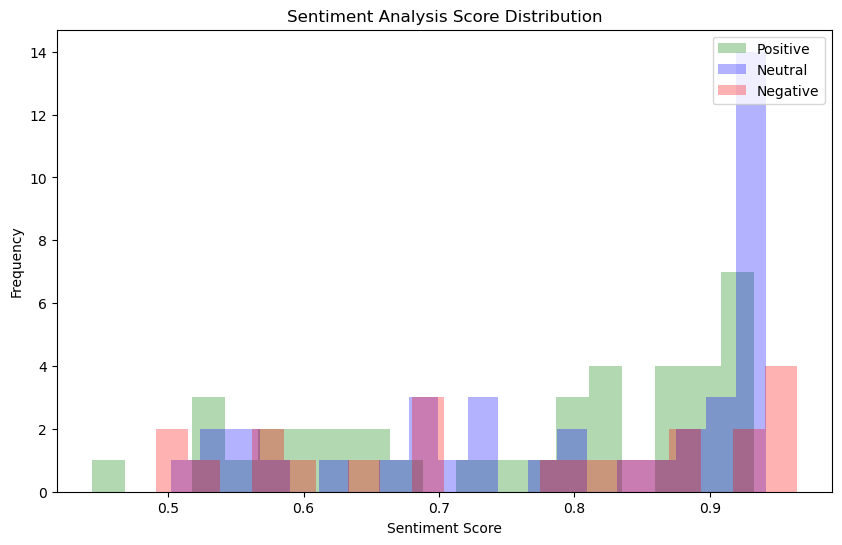

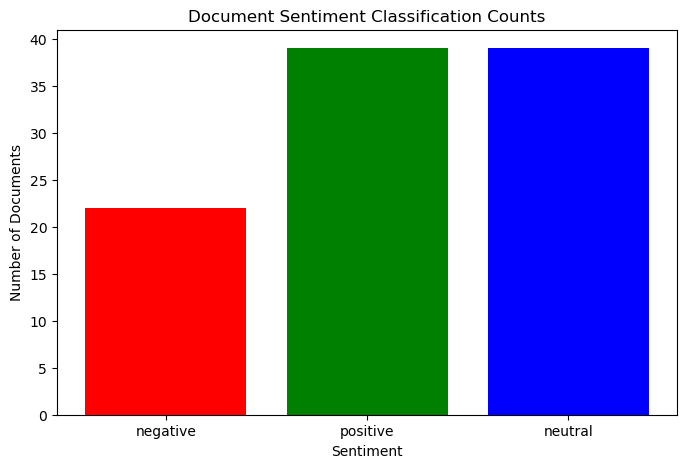

In [16]:
positive_scores = [result['Score'] for result in document_sentiments if result['Sentiment'] == 'positive']
neutral_scores = [result['Score'] for result in document_sentiments if result['Sentiment'] == 'neutral']
negative_scores = [result['Score'] for result in document_sentiments if result['Sentiment'] == 'negative']

plt.figure(figsize=(10, 6))
plt.hist(positive_scores, bins=20, alpha=0.3, label='Positive', color='green')
plt.hist(neutral_scores, bins=20, alpha=0.3, label='Neutral', color='blue')
plt.hist(negative_scores, bins=20, alpha=0.3, label='Negative', color='red')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Score Distribution')
plt.legend(loc='upper right')
plt.show()

sentiment_counts = Counter([result['Sentiment'] for result in document_sentiments])

colors = {'positive': 'green', 'neutral': 'blue', 'negative': 'red'}

plt.figure(figsize=(8, 5))
plt.bar(sentiment_counts.keys(), sentiment_counts.values(), color=[colors[sentiment] for sentiment in sentiment_counts.keys()])
plt.xlabel('Sentiment')
plt.ylabel('Number of Documents')
plt.title('Document Sentiment Classification Counts')
plt.show()

#### c)	Please present a workflow chart illustrating the steps of your analysis along with the techniques/functions used in each step.

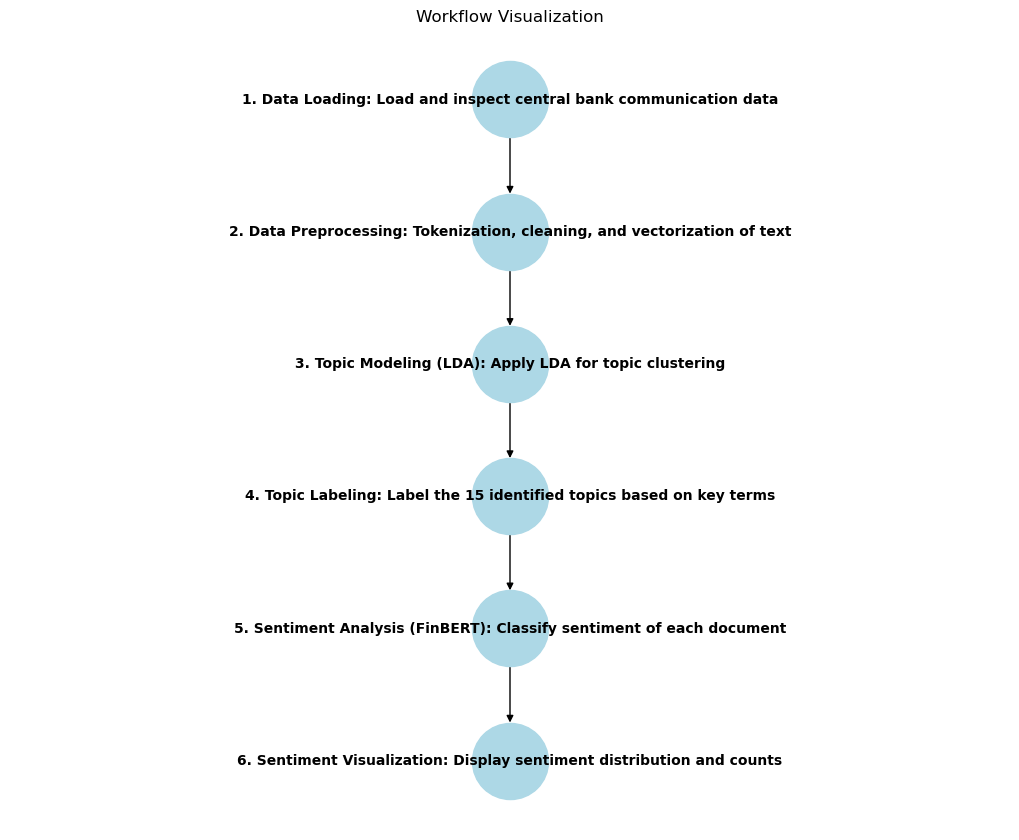

In [18]:
# Part (c) Workflow Visualization
import matplotlib.pyplot as plt
import networkx as nx

# Define steps in the workflow
workflow_steps = [
    "1. Data Loading: Load and inspect central bank communication data",
    "2. Data Preprocessing: Tokenization, cleaning, and vectorization of text",
    "3. Topic Modeling (LDA): Apply LDA for topic clustering",
    "4. Topic Labeling: Label the 15 identified topics based on key terms",
    "5. Sentiment Analysis (FinBERT): Classify sentiment of each document",
    "6. Sentiment Visualization: Display sentiment distribution and counts"
]

# Create a directed graph
workflow_graph = nx.DiGraph()
for i in range(len(workflow_steps) - 1):
    workflow_graph.add_edge(workflow_steps[i], workflow_steps[i + 1])

# Position nodes in a straight vertical line
pos = {workflow_steps[i]: (0, -i) for i in range(len(workflow_steps))}

# Draw the graph in a vertical straight line
plt.figure(figsize=(10, 8))
nx.draw(workflow_graph, pos, with_labels=True, font_size=10, node_size=3000, node_color="lightblue", font_weight="bold", arrows=True)
plt.title("Workflow Visualization")
plt.axis("off")
plt.show()
